<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Imports" data-toc-modified-id="1.-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Imports</a></span></li><li><span><a href="#2.-Functions" data-toc-modified-id="2.-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Functions</a></span></li><li><span><a href="#3.-Loading-Data" data-toc-modified-id="3.-Loading-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Loading Data</a></span></li><li><span><a href="#4.-Joining-Tables" data-toc-modified-id="4.-Joining-Tables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Joining Tables</a></span><ul class="toc-item"><li><span><a href="#4.1.-Filling-missing-dates" data-toc-modified-id="4.1.-Filling-missing-dates-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>4.1. Filling missing dates</a></span></li><li><span><a href="#4.2.-Merge" data-toc-modified-id="4.2.-Merge-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>4.2. Merge</a></span></li></ul></li><li><span><a href="#5.-Data-Cleaning-&amp;-Feature-Engineering" data-toc-modified-id="5.-Data-Cleaning-&amp;-Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. Data Cleaning &amp; Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Noteworthy-points" data-toc-modified-id="Noteworthy-points-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Noteworthy points</a></span></li><li><span><a href="#Data-Assessment" data-toc-modified-id="Data-Assessment-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Data Assessment</a></span></li><li><span><a href="#Data-Transformation" data-toc-modified-id="Data-Transformation-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Data Transformation</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Noteworthy-points" data-toc-modified-id="Noteworthy-points-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Noteworthy points</a></span></li></ul></li><li><span><a href="#7.-Modeling" data-toc-modified-id="7.-Modeling-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>7. Modeling</a></span><ul class="toc-item"><li><span><a href="#Noteworthy-points" data-toc-modified-id="Noteworthy-points-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Noteworthy points</a></span></li><li><span><a href="#Variable-Selection" data-toc-modified-id="Variable-Selection-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Variable Selection</a></span></li><li><span><a href="#GridSearch" data-toc-modified-id="GridSearch-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>GridSearch</a></span></li></ul></li><li><span><a href="#8.-Validation" data-toc-modified-id="8.-Validation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>8. Validation</a></span><ul class="toc-item"><li><span><a href="#Noteworthy-points" data-toc-modified-id="Noteworthy-points-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Noteworthy points</a></span></li></ul></li><li><span><a href="#9.-Conclusion" data-toc-modified-id="9.-Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>9. Conclusion</a></span></li></ul></div>

# 1. Imports

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

seed = 42


# 2. Functions

In [2]:
def corr_var_groups(df,corr_tresh):
    """creates a list of lists with groups of variables that have a pearson correlation 
    bigger than corr_tresh among each other"""
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []
    for col in corrMatrix:
        tresh_corr = corrMatrix[col][corrMatrix[col] >= corr_tresh].index.tolist()
        if tresh_corr and col not in already_in:
            already_in.update(set(tresh_corr))
            tresh_corr.append(col)
            result.append(tresh_corr)
    return result

def corr_heatmap(data):
    
    """ Takes as input a pandas dataframe and return a heatplot of the correlation matrix """

    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']

    x=corr['x']
    y=corr['y']
    size=corr['value'].abs()
    
    
    fig, ax = plt.subplots(figsize=(12,12))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(10, 240, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
    
        return palette[ind]
   

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    size_scale = 500
    
    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=[value_to_color(i) for i in corr['value']],#palette.apply(value_to_color()), # Vector of square color values, mapped to color palette
        marker='s'
    )

   
        # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Add color legend on the right side of the plot

    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot   

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )

    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right

# 3. Loading Data

Gathering all the data available 

In [3]:
# train data
path = '../input/walmart-recruiting-store-sales-forecasting/'
train = pd.read_csv(path+'train.csv.zip')
stores = pd.read_csv(path+'stores.csv')
features = pd.read_csv(path+'features.csv.zip')

# test data
test = pd.read_csv(path+'test.csv.zip')

# 4. Joining Tables

## 4.1. Filling missing dates


Some Store Departments have no data for some weeks so we are going to input these instances with zero sales. More details about this is available in the EDA Section.

In [4]:
# Creating new index
dates = train.Date.sort_values().unique()
depts = train.Dept.sort_values().unique()
strs = train.Store.sort_values().unique()

fill_index = pd.MultiIndex.from_product([dates, strs, depts],
                           names=['Date','Store','Dept'])

# Creating holidays dataframe
holidays = train.query('Store==1 & Dept==1')[['Date','IsHoliday']]


# Filling with reindex
train_new = train.set_index(['Date','Store','Dept']).Weekly_Sales.reindex(fill_index, fill_value = 0)
train_new = train_new.to_frame()
train_new.reset_index(inplace=True)

# merging back with holidays

train_new = train_new.merge(holidays, on='Date', how = 'left')


## 4.2. Merge

Merging the new train dataset with Stores and Features 

In [5]:
data = train_new.merge(stores, on = 'Store', how = 'left').merge(features.drop(columns=['IsHoliday']), on =['Store','Date'], how = 'left')

#data.IsHoliday_x.equals(data.IsHoliday_y)  # columns are equal so one can be dropped

# Saving merged data
#data.to_csv("data.csv")

# 5. Data Cleaning & Feature Engineering


## Noteworthy points 

- There are departments with missing dates in between entries, it may be the case that zero sales are not being accounted for. In a real situation, it is important to understand if this is the case or not. In this notebook, we will consider that missing values are indicatives of zero sales; therefore, this information might be useful for the model. We will input zero sales where there are missing department data.
- We found some negative Weekly Sales in the database. Again, it is important to understand, with a business expert or someone with experience with these data, which situations may lead to this. For this notebook, we will consider negative sales as refunds, and since the challenge asks for Sales prediction, we will replace negative values with 0. This might not be a big problem since negative values represent less then 0.4% of instance entries, but still, it is important to understand if the model is expected to predict negative values.

## Data Assessment

In [6]:
# Describe
data.describe().T

# negative values for Sales

,count,mean,std,min,25%,50%,75%,max
Store,521235.0,23.000000,12.987186,1.000,12.000,23.000000,34.000000,45.000000
Dept,521235.0,46.061728,29.206127,1.000,22.000,42.000000,72.000000,99.000000
Weekly_Sales,521235.0,12925.492316,21369.830449,-4988.940,134.790,4496.140000,16058.945000,693099.360000
Size,521235.0,130287.600000,63112.178618,34875.000,70713.000,126512.000000,202307.000000,219622.000000
Temperature,521235.0,60.663782,18.443517,-2.060,47.430,62.670000,74.950000,100.140000
Fuel_Price,521235.0,3.358607,0.458984,2.472,2.933,3.445000,3.735000,4.468000
MarkDown1,184680.0,6855.587430,8181.537384,0.270,1679.190,4972.590000,8873.582500,88646.760000
MarkDown2,132597.0,3218.965504,9265.286079,-265.760,37.200,187.040000,1785.290000,104519.540000
MarkDown3,165726.0,1349.853021,9285.000926,-29.100,4.700,22.700000,100.000000,141630.610000
MarkDown4,159165.0,3303.858142,6209.642794,0.220,483.270,1419.420000,3496.080000,67474.850000


In [7]:
# Types
print(data.head(),'\n\n',data.dtypes) 

# datatypes are all good but can be optimized to reduce memory usage

         Date  Store  Dept  Weekly_Sales  IsHoliday Type    Size  Temperature  \
0  2010-02-05      1     1      24924.50      False    A  151315        42.31   
1  2010-02-05      1     2      50605.27      False    A  151315        42.31   
2  2010-02-05      1     3      13740.12      False    A  151315        42.31   
3  2010-02-05      1     4      39954.04      False    A  151315        42.31   
4  2010-02-05      1     5      32229.38      False    A  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   
2       2.572        NaN        NaN        NaN        NaN        NaN   
3       2.572        NaN        NaN        NaN        NaN        NaN   
4       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.096358       

In [8]:
# Check for Nulls
print(data.count(),'\n\n',data.isna().sum()) 

# null values only on markdown columns

Date            521235
Store           521235
Dept            521235
Weekly_Sales    521235
IsHoliday       521235
Type            521235
Size            521235
Temperature     521235
Fuel_Price      521235
MarkDown1       184680
MarkDown2       132597
MarkDown3       165726
MarkDown4       159165
MarkDown5       185895
CPI             521235
Unemployment    521235
dtype: int64 

 Date                 0
Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       336555
MarkDown2       388638
MarkDown3       355509
MarkDown4       362070
MarkDown5       335340
CPI                  0
Unemployment         0
dtype: int64


In [9]:
# Stores entries
# data['Store'].value_counts()  

# some stores have slightly more entries than others...
# this was fixed using imputation 

#data.groupby(['Store','Dept']).agg(dates = ('Date', 'count'))

# all departments now have the same number of entries

dates
Store Dept       
1     1       143
      2       143
      3       143
      4       143
      5       143
      6       143
      7       143
      8       143
      9       143
      10      143
      11      143
      12      143
      13      143
      14      143
      16      143
      17      143
      18      143
      19      143
      20      143
      21      143
      22      143
      23      143
      24      143
      25      143
      26      143
      27      143
      28      143
      29      143
      30      143
      31      143
      32      143
      33      143
      34      143
      35      143
      36      143
      37      143
      38      143
      39      143
      40      143
      41      143
      42      143
      43      143
      44      143
      45      143
      46      143
      47      143
      48      143
      49      143
      50      143
      51      143
      52      143
      54      143
      55      143
      56      143
      58      143
      59      143
      60      143
      65      143
      67      143
      71      143
      72      143
      74      143
      77      143
      78      143
      79      143
      80      143
      81      143
      82      143
      83      143
      85      143
      87      143
      90      143
      91      143
      92      143
      93      143
      94      143
      95      143
      96      143
      97      143
      98      143
      99      143
2     1       143
      2       143
      3       143
      4       143
      5       143
      6       143
      7       143
      8       143
      9       143
      10      143
      11      143
      12      143
      13      143
      14      143
      16      143
      17      143
      18      143
      19      143
      20      143
      21      143
      22      143
      23      143
      24      143
      25      143
      26      143
      27      143
      28      143
      29      143
      30      143
      31      143
      32      143
      33      143
      34      143
      35      143
      36      143
      37      143
      38      143
      39      143
      40      143
      41      143
      42      143
      43      143
      44      143
      45      143
      46      143
      47      143
      48      143
      49      143
      50      143
      51      143
      52      143
      54      143
      55      143
      56      143
      58      143
      59      143
      60      143
      65      143
      67      143
      71      143
      72      143
      74      143
      77      143
      78      143
      79      143
      80      143
      81      143
      82      143
      83      143
      85      143
      87      143
      90      143
      91      143
      92      143
      93      143
      94      143
      95      143
      96      143
      97      143
      98      143
      99      143
3     1       143
      2       143
      3       143
      4       143
      5       143
      6       143
      7       143
      8       143
      9       143
      10      143
      11      143
      12      143
      13      143
      14      143
      16      143
      17      143
      18      143
      19      143
      20      143
      21      143
      22      143
      23      143
      24      143
      25      143
      26      143
      27      143
      28      143
      29      143
      30      143
      31      143
      32      143
      33      143
      34      143
      35      143
      36      143
      37      143
      38      143
      39      143
      40      143
      41      143
      42      143
      43      143
      44      143
      45      143
      46      143
      47      143
      48      143
      49      143
      50      143
      51      143
      52      143
      54      143
      55      143
      56      143
      58      143
      59      143
      60      143
      65      143
      67      14

##  Data Transformation

- What are negative sales? (1285 entries in the test database  = 0.3% max of -4988.94 and total of -88161.56 adding up to -0,000013086% of the total sales) (Replace with 0)

- Fill Nulls in markdown variables

- Encode variable "Type" (one hot)

- Parse Dates to label encoding (years, months and weeks of the year)

- Add Easter and Halloween as holidays

- Create variables #weeks before holiday

- Create groups for departments that have similar sales profiles

- Change datatypes to better memory usage


In [10]:
# Replacing Negative Sales with 0
data.loc[data.Weekly_Sales < 0, 'Weekly_Sales'] = 0

In [11]:
# FillNA markdown variables with -9999
data.fillna(-9999,inplace = True)

In [12]:
# OneHot encoding variable store type
data = pd.get_dummies(data,columns=['Type'])

In [13]:
# parse data into month and weekofyear columns
data['Month'] = data.Date.apply(lambda x : datetime.strptime(str(x),'%Y-%m-%d').month)
data['WeekofYear'] = data.Date.apply(lambda x : datetime.strptime(str(x),'%Y-%m-%d').isocalendar()[1])
data['Year'] = data.Date.apply(lambda x : datetime.strptime(str(x),'%Y-%m-%d').year)



In [14]:
# holidays weeks
#data.query('IsHoliday == True').WeekofYear.unique()

#Add Halloween
data.loc[data["WeekofYear"] == 44,'IsHoliday'] = True

#Add Easter
data.loc[(data.Year==2010) & (data.WeekofYear==13), 'IsHoliday'] = True
data.loc[(data.Year==2011) & (data.WeekofYear==16), 'IsHoliday'] = True
data.loc[(data.Year==2012) & (data.WeekofYear==14), 'IsHoliday'] = True

#Creating dummies for holidays and weekbefore holidays
data['IsHoliday'] = data.query('IsHoliday == True').WeekofYear
data['IsHoliday_1'] = data.query('WeekofYear in (5, 35, 43, 46, 51)').WeekofYear

data = pd.concat([pd.get_dummies(data,columns=['IsHoliday','IsHoliday_1'],prefix=['Holiday','Week_Before_Holiday']),data['IsHoliday']], axis = 1)
data = data.fillna(0)

In [15]:
# Department Groups

df = data.groupby(['WeekofYear','Dept']).agg(mean_weekly_sales = ('Weekly_Sales','mean')).reset_index(level=['Dept'])

df_dept_agg = pd.pivot_table(df, values='mean_weekly_sales', index=['WeekofYear'],
                    columns=['Dept'])

corr_groups = corr_var_groups(df_dept_agg,0.85)

for i,group in enumerate(corr_groups,1):
    data.loc[data.Dept.isin(group),'Dept_groups'] = i

data = data.fillna(0)

In [16]:
# reducing memory usage

print(f'data memory usage : {data.memory_usage(deep = True).sum() / 1024**2} Mb')

ints = data.select_dtypes(include='int').columns.values.tolist()
floats = data.select_dtypes(include='float').columns.values.tolist()

for i in ints:
    data[i] = pd.to_numeric(data[i],downcast = 'integer')
    
for i in floats:
    data[i] = pd.to_numeric(data[i],downcast = 'float')

print(f'data memory usage after optimizing dtypes : {data.memory_usage(deep = True).sum() / 1024**2} Mb')

data memory usage : 136.81578159332275 Mb
data memory usage after optimizing dtypes : 94.06617641448975 Mb


# EDA

The Exploratory Data analysis is done so we can familiarize ourselves with the data and gain insight and intuition about the problem. This comes in hand to understand future model behavior or eventual unexpected results. In this phase, is essential to follow up with business experts and other stakeholders.


## Noteworthy points 

- It is seen that the sales along the year have a great dependency on the department, with different departments showing distinct sales curves. Holidays also seems to affect different departments in different ways.
- It is seen that in general terms the last two holidays are way important then the other, as shown by the mean sales as function of week of the year.
- Halloween and Easter (which are not included in the original Holidays variable) have a big impact in sales for some departments

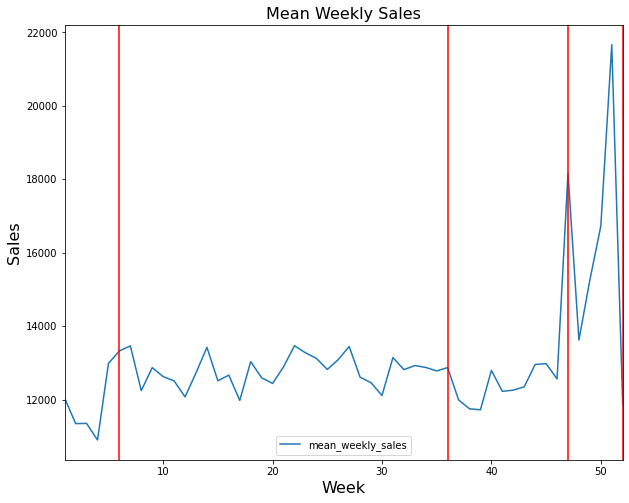

In [17]:
# weekly sales by week with holidays in red
data.groupby('WeekofYear').agg(mean_weekly_sales = ('Weekly_Sales','mean')).plot(figsize = (10,8))

xcoords = [6, 36, 47, 52]
for xc in xcoords:
    plt.axvline(x=xc, color = 'red')
    
plt.title("Mean Weekly Sales", fontsize=16);
plt.ylabel('Sales', fontsize=16);
plt.xlabel('Week', fontsize=16);

Some departments show increase in sales in other dates, it is seen that halloween week 44 and easter have great inpact in some departments.

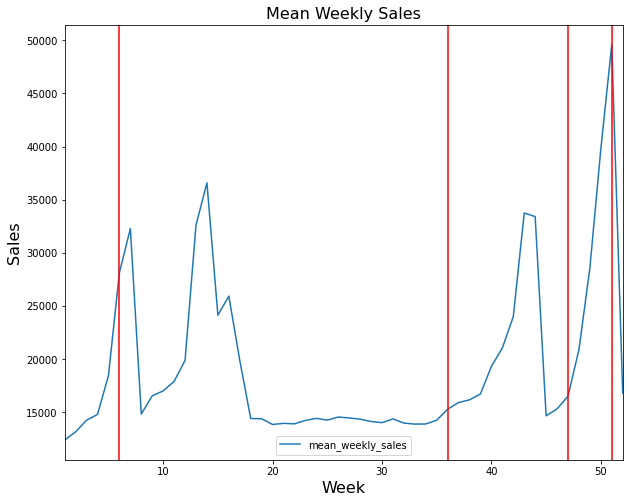

In [18]:
# Weekly Sales - Different departments
data.query(" Dept == 1").groupby('WeekofYear').agg(mean_weekly_sales = ('Weekly_Sales','mean')).plot(figsize = (10,8))

xcoords = [6, 36, 47, 51]
for xc in xcoords:
    plt.axvline(x=xc, color = 'red')
    
plt.title("Mean Weekly Sales", fontsize=16);
plt.ylabel('Sales', fontsize=16);
plt.xlabel('Week', fontsize=16);

#9,12 incresing in the middle of the year
#2 max in sales x weeks before a specific holiday
#1,18 seems to have other importat dates (week 44 halloween)

 Differences in sales between distinct Stores and Departments

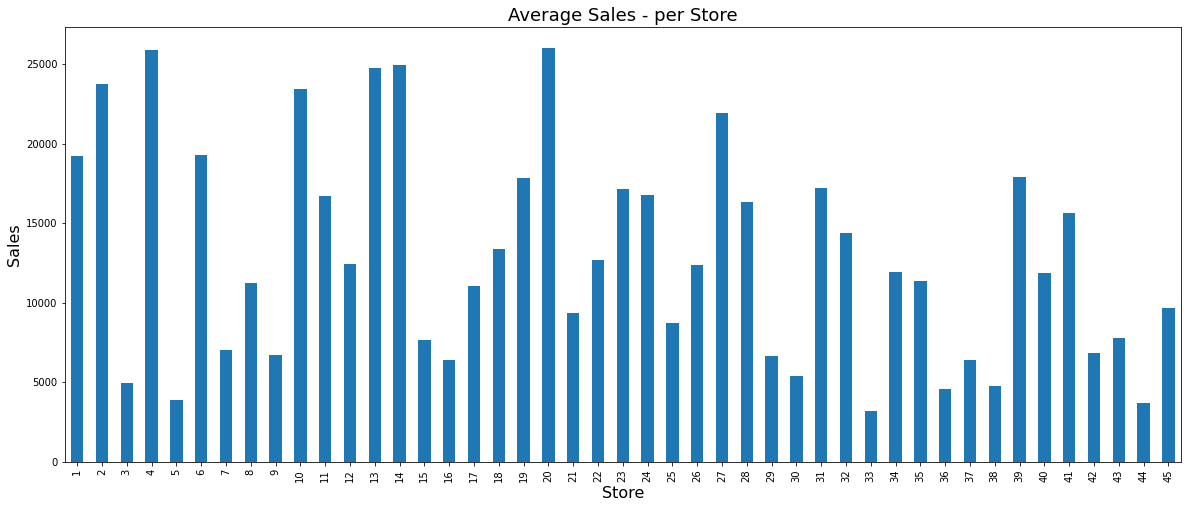

In [19]:
# Sales for different stores
weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20,8))
weekly_sales.plot.bar();
plt.title('Average Sales - per Store', fontsize=18);
plt.ylabel('Sales', fontsize=16);
plt.xlabel('Store', fontsize=16);


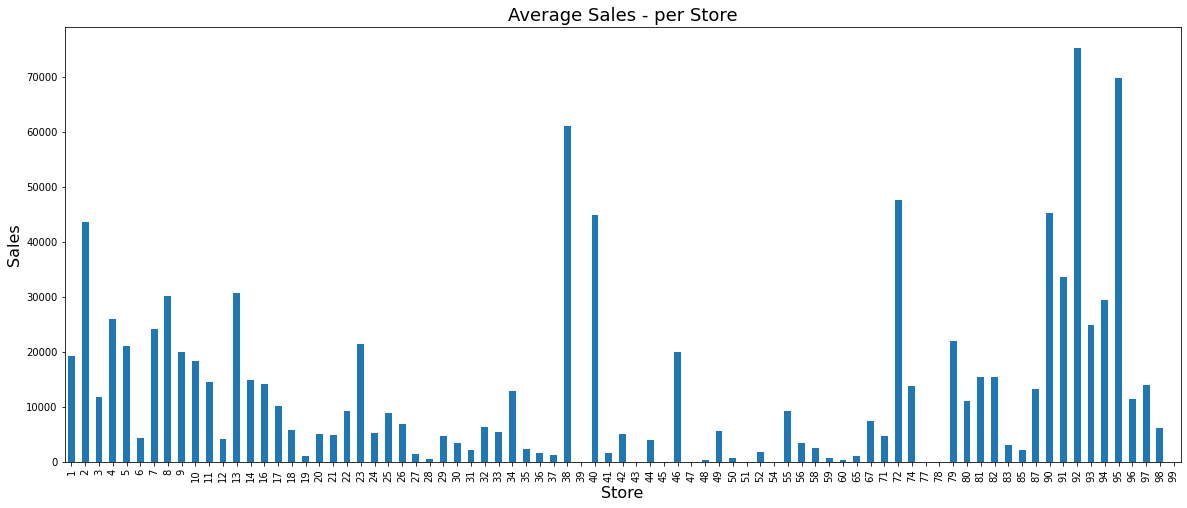

In [20]:
# Sales for different departments
weekly_sales = data['Weekly_Sales'].groupby(data['Dept']).mean()
plt.figure(figsize=(20,8))
weekly_sales.plot.bar();
plt.title('Average Sales - per Store', fontsize=18);
plt.ylabel('Sales', fontsize=16);
plt.xlabel('Store', fontsize=16);

Seeing a correlation plot, there is no strong correlation between the features and Sales. The strongest correlations being the size and type of the store.

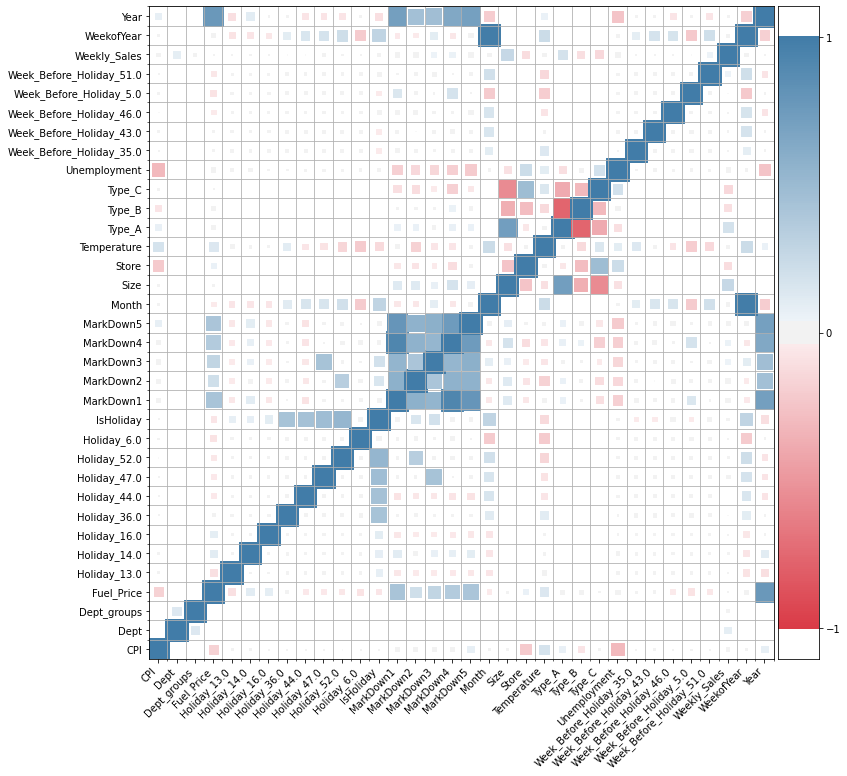

In [21]:
# correlation pearson
corr_heatmap(data)

# 7. Modeling

It is good practice to start with simpler models and gradually build up complexity. Simpler models are easier to interpret and can give good insight about the importance and influence of variables in the final result. Also, it is good to have an initial model ready and running as soon as possible so we can get a baseline of performance for the next iterations. In this Notebook, however, I will skip this phase since, as shown in previous sections, the dependent variable is highly non-linear. This means that simpler models such as linear regression will perform poorly and probably won't be of much use for interpretability.

I choose to jump right into a random forest model, mainly because this algorithm can deal with non-linear data with ease. Random Forests also can handle data without standardizing or normalizing, and we don't have to worry about the imputation of cyclical time variables such as month and week of the year. This simplifies the preprocessing and saves us some time, also the model will give us a pretty good approximation of an "optimum" model right away.

## Noteworthy points

- With data that shows seasonality of some kind, using a test set from the same time period as used for training tends to underestimate the model error. Therefore, in these cases, it is important to test the model in an out of time validation set.
- We will use MAE as the evaluation metric maily because of it simplicity and because it gives a good sense of error in the same unity as the response



In [22]:
# out of time validation set
oot_data = data.query("Date >= '2012-07-01'")

oot_X = oot_data.drop(columns = ['Date','Weekly_Sales'])
oot_y = oot_data.Weekly_Sales

# in time validation set
it_data = data.query("Date < '2012-07-01'")

data_sample = it_data.sample(frac=1, random_state = seed)

X = data_sample.drop(columns = ['Date','Weekly_Sales'])
y = data_sample.Weekly_Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [23]:
X_train.shape,y_train.shape,X_test.shape,oot_X.shape

((307710, 33), (307710,), (151560, 33), (61965, 33))

In [24]:
X_train.head()

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_A,Type_B,Type_C,Month,WeekofYear,Year,Holiday_6.0,Holiday_13.0,Holiday_14.0,Holiday_16.0,Holiday_36.0,Holiday_44.0,Holiday_47.0,Holiday_52.0,Week_Before_Holiday_5.0,Week_Before_Holiday_35.0,Week_Before_Holiday_43.0,Week_Before_Holiday_46.0,Week_Before_Holiday_51.0,IsHoliday,Dept_groups
262428,45,85,118221,69.320000,3.842,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,185.671936,8.521,0,1,0,6,24,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,9.0
253311,23,26,114533,67.209999,3.973,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,134.855164,4.781,0,1,0,6,22,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5.0
313982,7,28,70713,47.340000,3.538,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,194.877975,8.622,0,1,0,9,39,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
390207,3,32,37392,60.119999,3.555,6129.279785,1802.839966,-9999.0,301.480011,1929.709961,224.132019,6.833,0,1,0,2,8,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
158317,20,45,203742,35.470001,3.046,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,204.824921,7.484,1,0,0,12,48,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


In [25]:
rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
rand_reg = rf.fit(X_train, y_train)

In [26]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("OOT_test MAE: {:.2f}".format(mean_absolute_error(oot_y,rand_reg.predict(oot_X))))

train MAE: 445.25
test MAE: 1197.72
OOT_test MAE: 1433.05


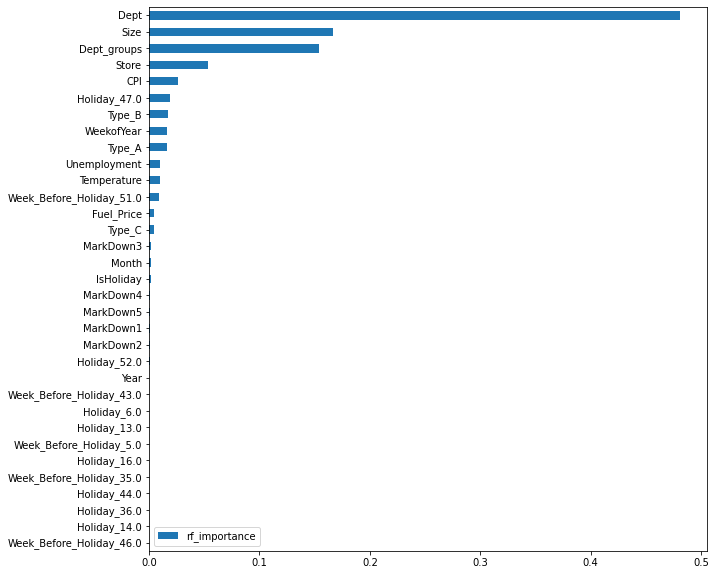

In [27]:
imp_rf = pd.DataFrame(rand_reg.feature_importances_).transpose()
imp_rf.columns = X_train.columns
imp_rf = imp_rf.transpose().sort_values(0)
imp_rf.columns = ['rf_importance']

imp_rf.plot.barh(figsize=(10,10));

## Variable Selection


In [28]:
keep_cols = imp_rf.sort_values('rf_importance',ascending=False)[:13].index.values.tolist()

# out of time validation set
oot_data = data.query("Date >= '2012-07-01'")

oot_X = oot_data[keep_cols]
oot_y = oot_data.Weekly_Sales

# in time validation set
it_data = data.query("Date < '2012-07-01'")

data_sample = it_data.sample(frac=1, random_state = seed)

X = data_sample[keep_cols]
y = data_sample.Weekly_Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [29]:
rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
rand_reg = rf.fit(X_train, y_train)

In [30]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("OOT_test MAE: {:.2f}".format(mean_absolute_error(oot_y,rand_reg.predict(oot_X))))

train MAE: 448.79
test MAE: 1210.01
OOT_test MAE: 1418.35


with the exclusion of some low importance variables the performance actualy improved in the out of time set while slightly descreasing in the train and validation set. This is evidence of some overfiting and variables with high noise and low correlation with the target (such as markdown variables) could be the cause for this. So in this case we are better off droping those variables.

## GridSearch

Let's try to improve our model with hyperparameter tunning

In [31]:
rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
param_grid  = {'max_depth': [20, 25, 30],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 3],
               'n_estimators': [50, 80]}

grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,verbose=2)

# Fit the random search model
grid.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  32.1s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  30.1s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  30.6s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  30.8s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  31.0s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  48.0s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  48.7s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=  33.4s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=  34.4s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=  34.5s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=  39.6s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=50, total=  34.5s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=80 
[CV]  max_depth=25, min_samples_leaf=1, min_samples_split=3, n_estimators=80, total=  53.6s
[CV] max_depth=25, min_samples_leaf=1, min_samples_split=3, n_e

[CV]  max_depth=30, min_samples_leaf=1, min_samples_split=3, n_estimators=80, total=  54.7s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=  32.6s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=  32.5s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=  32.8s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=  32.5s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=  32.8s
[CV] max_depth=30, min_samples_leaf=2, min_samples_split=2, n_e

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 84.4min finished


NameError: name 'random_grid' is not defined

In [33]:
print(grid.best_params_)

rf_reg = grid.best_estimator_.fit(X_train, y_train)

{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}


In [34]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rf_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rf_reg.predict(X_test))))
print("OOT_test MAE: {:.2f}".format(mean_absolute_error(oot_y,rf_reg.predict(oot_X))))

train MAE: 490.77
test MAE: 1213.03
OOT_test MAE: 1418.77


We didn't achive any improvement in performance. However, a more complete hiperparameter optimization could improve model performance. Due to time and resources limitations, we are not going to pursue further hiperparameter optimization, but in a real case we might test a wider range of parameters as long as test other ML algorithms, restricted to time and performance requirements of the project. 

# 8. Validation

In this phase it is important to check with the steakholders if the model results makes sense. It is good practice to check some cases see if they represent what is expected in a business perspective.
Libraries that explain variables and the results of the models such as shap, eli5 and lime can come in hand to explain why the model gives a certain response to a entry.

## Noteworthy points

- Here we are going to briefly look at some shap values, in a real case it is recomended to check at edge cases or/and benchmark cases.
- The variable Store is considered in the model, however if the model is intended to predict sales for new stores this variable can't be used.

In [ ]:
explainer = shap.TreeExplainer(rf_reg, approximate = True)
rf_shap_values = explainer.shap_values(X_test.iloc[0:100,:])
shap.summary_plot(rf_shap_values, X_test.iloc[0:100,:])

# 9. Conclusion

This case is a first iteration along many that may be necessary to complete a ML model. There are some key aspects that should be kept in mind going forward in a real problem:

- See if it is possible to get more data, specialy about departments and stores characteristics. More precise data about holidays might be helpful too.
- See if markdown variables are expected to impact the model results, if so, we can look at ways to reduce variable noise or other ways to improve variable quality.
- Variables such as temperature, CPI and fuel_price could be hard to implement in a productive pipeline. It is important to consider the possible caveats of this implementation.
- The model performance can be improved in many ways, however it is key to consider time and resources availability, how the model will be used and how its peformance will be translated into business results. In many cases the amount of work to achieve a small increment in performance does not translates into significant and measurable results.